In [147]:
import pandas as pd
from scipy.stats import norm

import math
import matplotlib.pyplot as plt




 ### Preprocessing the data

#### Data is taken from the kaggle competition https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/data

In [148]:
train_fraction=0.8
seed=None
confidence=0.95
moment_order=6

In [149]:
# read train.csv and get just the id and psych_disturb columns and split them in test and train
path='../data/equity-post-HCT-survival-predictions/train.csv'
df= pd.read_csv(path, usecols=['ID', 'psych_disturb'])
df.head()

,ID,psych_disturb
0,0,No
1,1,No
2,2,No
3,3,No
4,4,No


In [150]:
df_filtered = df[df['psych_disturb'].str.upper().isin(['YES', 'NO'])]
df_filtered['psych_disturb'] = df_filtered['psych_disturb'].str.upper().map({'YES': 1, 'NO': 0})
train_df = df_filtered.sample(frac=train_fraction, random_state=seed)
test_df = df_filtered.drop(train_df.index)
df_filtered.head()

C:\Users\pc\AppData\Local\Temp\ipykernel_3108\2540558827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['psych_disturb'] = df_filtered['psych_disturb'].str.upper().map({'YES': 1, 'NO': 0})


,ID,psych_disturb
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


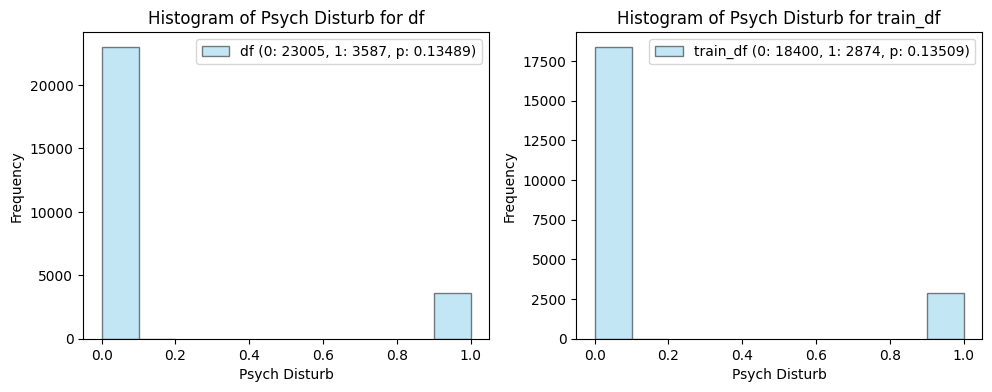

In [151]:

# Calculate counts of 0s and 1s
df_counts = df_filtered['psych_disturb'].value_counts()
train_df_counts = train_df['psych_disturb'].value_counts()
p_df= df_counts[1] / (df_counts[0] + df_counts[1])
p_train_df= train_df_counts[1] / (train_df_counts[0] + train_df_counts[1])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
color = 'skyblue'
edgecolor = 'black'
bin_width = 0.1
bins = [0, 0.1, 0.9, 1]

# Histogram for df
ax1.hist(df_filtered['psych_disturb'], bins=bins, alpha=0.5, label=f'df (0: {df_counts[0]}, 1: {df_counts[1]}, p: {p_df:.5f})', color=color, edgecolor=edgecolor, width=bin_width, align='mid')
ax1.set_xlabel('Psych Disturb')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Psych Disturb for df')
ax1.legend(loc='upper right')

# Histogram for train_df
ax2.hist(train_df['psych_disturb'], bins=bins, alpha=0.5, label=f'train_df (0: {train_df_counts[0]}, 1: {train_df_counts[1]}, p: {p_train_df:.5f})', color=color, edgecolor=edgecolor, width=bin_width,align='mid')
ax2.set_xlabel('Psych Disturb')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Psych Disturb for train_df')
ax2.legend(loc='upper right')

# Adjust layout to add space between subplots
plt.tight_layout(pad=1.0)

# Show plot
plt.show()

### Estimating the parameter of the bernoulli distribution of psych_disturb with confidence intervals

In [152]:
p_estimate= train_df['psych_disturb'].mean()
alpha= round(1 - confidence,2)
z_score = norm.ppf(1 - (alpha / 2))



 Using the approximation that n is large enough to use the normal distribution (according to the central limit theorem)


In [153]:
lower_ci_clt= p_estimate - z_score / (2*math.sqrt(len(train_df)))
upper_ci_clt= p_estimate + z_score / (2*math.sqrt(len(train_df)))
print(f'Confidence interval for p is: [{lower_ci_clt:.5f}, {upper_ci_clt:.5f}]')

Confidence interval for p is: [0.12838, 0.14181]


Using Hoeffding's inequality

In [154]:
lower_ci_hoefdding= p_estimate - math.sqrt(math.log(2/alpha)/(2*len(train_df)))
upper_ci_hoefdding= p_estimate + math.sqrt(math.log(2/alpha)/(2*len(train_df)))
print(f'Confidence interval for p is: [{lower_ci_hoefdding:.5f}, {upper_ci_hoefdding:.5f}]')


Confidence interval for p is: [0.12578, 0.14441]


Using Chebyshev's inequality
$$
\text{Lower CI} = p_{\text{estimate}} - \frac{m}{\left(2 \times (1 - \text{confidence})\right)^{\frac{1}{2}}} \times \frac{1}{\sqrt{n}}
$$

$$
\text{Upper CI} = p_{\text{estimate}} + \frac{m}{\left(2 \times (1 - \text{confidence})\right)^{\frac{1}{m}}} \times \frac{1}{\sqrt{n}}
$$


In [155]:
lower_ci_chebyshev= p_estimate - 1/ (2*math.sqrt(len(train_df) * alpha))
upper_ci_chebyshev= p_estimate + 1/ (2*math.sqrt(len(train_df) * alpha))

Using Marcinkiewicz-Zygmund inequality with high-order moment



$$
\text{Lower CI} = p_{\text{estimate}} - \frac{m}{\left(2 \times (1 - \text{confidence})\right)^{\frac{1}{m}}} \times \frac{1}{\sqrt{n}}
$$

$$
\text{Upper CI} = p_{\text{estimate}} + \frac{m}{\left(2 \times (1 - \text{confidence})\right)^{\frac{1}{m}}} \times \frac{1}{\sqrt{n}}
$$


### Legend:
- $p_{\text{estimate}}$: Estimated probability (the mean of samples in this case).
- $m$: Moment order.
- $\text{confidence}$: Confidence level.
- $n$: Number of samples in the training dataset (`train_df`).

In [156]:
import math

# Calculate the square root of 10
root_10 = math.sqrt(10)

# Calculate the square root of the result
root_of_root_10 = math.sqrt(root_10)

print(f'The root of the root of 10 is: {root_of_root_10}')

The root of the root of 10 is: 1.7782794100389228


In [157]:
lower_ci_marcin_zyg= p_estimate - ( moment_order * (1/ (2 * alpha)**(1/moment_order)))/ math.sqrt(len(train_df))
upper_ci_marcin_zyg= p_estimate + ( moment_order * (1/ (2 * alpha)**(1/moment_order)))/ math.sqrt(len(train_df))

In [158]:
dict_ci = {'CLT': [lower_ci_clt, upper_ci_clt], 'Hoeffding': [lower_ci_hoefdding, upper_ci_hoefdding],
           'Chebyshev': [lower_ci_chebyshev, upper_ci_chebyshev],
           f'Marcinkiewicz-Zygmund (moment_order={moment_order})': [lower_ci_marcin_zyg, upper_ci_marcin_zyg]}
sorted_dict_ci = dict(sorted(dict_ci.items(), key=lambda item: item[1][1] - item[1][0], reverse=True))

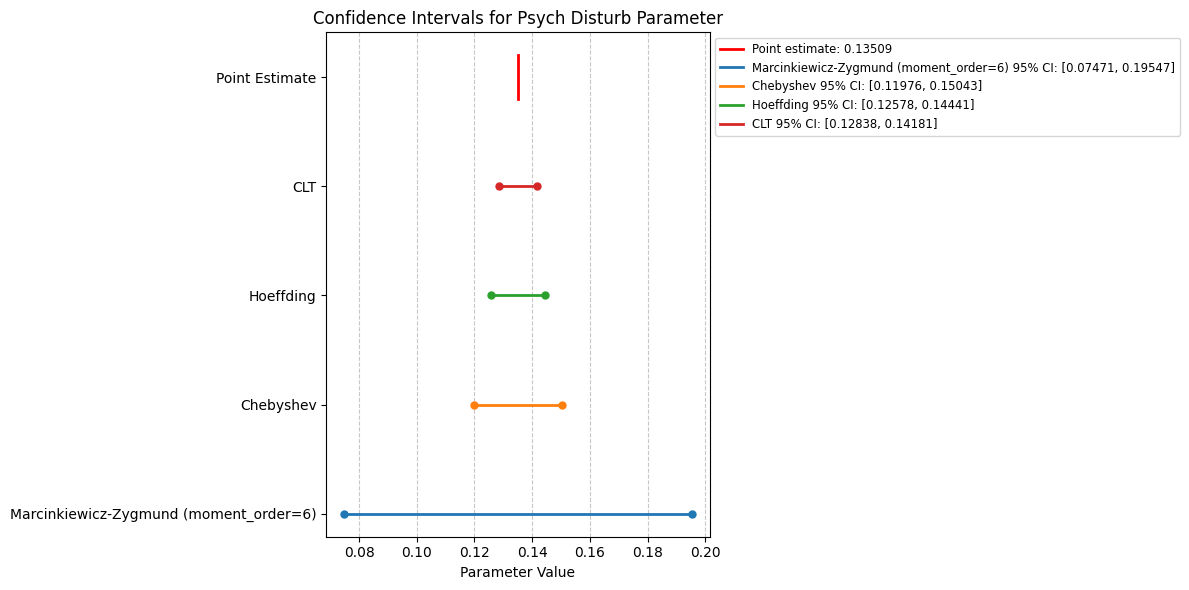

In [159]:
# Create figure for horizontal confidence intervals
fig, ax = plt.subplots(figsize=(12, 6))

# Define y positions for different intervals
# Loop over dictionary items to get the y positions
y_positions = [i for i in range(len(sorted_dict_ci)+1)]
labels = list(sorted_dict_ci.keys())
# Add the point estimate label at the end
labels.append('Point Estimate')
# Generate colors for each interval dynamically
colors = plt.cm.tab10(range(len(sorted_dict_ci)))


# Plot horizontal lines
# Point estimate
ax.plot([p_estimate, p_estimate], [y_positions[len(y_positions)-1]-0.2, y_positions[len(y_positions)-1]+0.2],
        linewidth=2, color='red',
        label=f'Point estimate: {p_estimate:.5f}')

# Loop over the dictionary items to plot the confidence intervals with larger intervals laster
for i, (label, (lower_ci, upper_ci)) in enumerate(sorted_dict_ci.items()):
    # Plot horizontal line for each confidence interval
    ax.plot([lower_ci, upper_ci], [y_positions[i], y_positions[i]],
            linewidth=2, color=colors[i],
            label=f'{label} {int(confidence*100)}% CI: [{lower_ci:.5f}, {upper_ci:.5f}]')

    ax.plot([lower_ci, upper_ci], [y_positions[i], y_positions[i]], 'o',color=colors[i], markersize=5)


# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(labels)
ax.set_xlabel('Parameter Value')
ax.set_title('Confidence Intervals for Psych Disturb Parameter')
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
# put the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
# Set x-axis limits with padding

plt.tight_layout()
plt.show()